In [1]:
import datetime as dt
import pandas as pd
from wetterdienst.provider.dwd.observation import DwdObservationRequest
import dask
from dask.distributed import Client
import json
import xarray as xr

# 1️⃣ Create request
request = DwdObservationRequest(
    parameters=("daily", "climate_summary", "temperature_air_mean_2m"),
    start_date=dt.datetime(1989, 1, 1),
    end_date=dt.datetime(2014, 12, 1)
)

# 2️⃣ Fetch all station metadata
stations = request.all().df.to_pandas()  # StationsResult

# 3️⃣ Get station IDs
station_ids = stations['station_id'].tolist()

# 4️⃣ Iterate over station IDs to get data
dfs = []
sid = station_ids[1]
# for sid in station_ids:
df_station = request.filter_by_station_id(station_id=sid).values.all().df.to_pandas()#  # returns DataFrame
df_station['date'] = df_station['date'].dt.tz_localize(None)
df_station = df_station.set_index('date')

# dfs.append(df_station)

# 5️⃣ Combine all stations
# df_all = pd.concat(dfs, ignore_index=True)
subset = stations.loc[stations['station_id'] == sid, ['latitude', 'longitude']]

if subset.empty:
    raise ValueError(f"No station found with id {sid}")
elif len(subset) > 1:
    raise ValueError(f"Multiple stations found with id {sid}")

lat, lon = subset.values[0]
df_station['latitude'] = lat
df_station['longitude'] = lon


# Assume df is your DataFrame with index=date and columns as described
df = df_station  # rename for clarity
df = df.reset_index()  # make 'date' a column

# 1️⃣ Create a list of unique station IDs
stations = df['station_id'].unique()

# 2️⃣ Create a Dataset for time-dependent variables
ds_time = xr.Dataset(
    {
        'value': (('time', 'station_id'), df.pivot(index='date', columns='station_id', values='value').values),
        'quality': (('time', 'station_id'), df.pivot(index='date', columns='station_id', values='quality').values)
    },
    coords={
        'time': pd.to_datetime(df['date'].unique()),
        'station_id': stations
    }
)

# 3️⃣ Add station-level coordinates
# Pick the first occurrence per station
station_coords = df.drop_duplicates('station_id').set_index('station_id')
ds_time = ds_time.assign_coords(
    resolution=("station_id", station_coords['resolution']),
    dataset=("station_id", station_coords['dataset']),
    parameter=("station_id", station_coords['parameter']),
    latitude=("station_id", station_coords['latitude']),
    longitude=("station_id", station_coords['longitude'])
)


geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          f"{lon}",
          f"{lat}",
        ],
        "type": "Point"
      }
    }
  ]
}

# Start a local Dask cluster
client = Client(n_workers=40, threads_per_worker=2, memory_limit="40GB")
print(client)


hyras_ds = []
for var in ['tas']:
    import climdata
    clim = climdata.extract_data(
        overrides=[
                "dataset=hyras",
                f"variables=[{var}]",
                "data_dir=/beegfs/muduchuru/data", #optional 
                f"time_range.start_date=1989-01-01",
                f"time_range.end_date=2014-12-31",
                f"aoi='{json.dumps(geojson)}'",
                "dsinfo.mswx.params.google_service_account=./.climdata_conf/service.json",
        ],
        save_to_file=False
    )
    hyras_ds.append(clim['dataset'])

import xarray as xr
hyras_ds = xr.merge(hyras_ds,compat='override')

import ee
# ee.Authenticate()
ee.Initialize(project='ee-kaushikreddym')
import geemap
from geeagri.extract import (
    extract_timeseries_to_point,
    extract_timeseries_to_polygon,
    TimeseriesExtractor,
)

era5 = ee.ImageCollection("ECMWF/ERA5/DAILY")
era5_df = extract_timeseries_to_point(
    lat=lat,
    lon=lon,
    image_collection=era5,
    start_date="1989-01-01",
    end_date="2014-12-31",
    band_names=[
        "mean_2m_air_temperature",
    ],
    scale=11132,
)
era5_df['time'] = pd.to_datetime(era5_df['time'])
era5_ds = era5_df.set_index(['time']).to_xarray()
era5_ds['mean_2m_air_temperature'] = era5_ds['mean_2m_air_temperature']-273.15

<Client: 'tcp://127.0.0.1:39169' processes=5 threads=10, memory=186.26 GiB>
⬇️  Checking: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/tas_hyras_1_1989_v6-0_de.nc
✔️  Exists locally: /beegfs/muduchuru/data/hyras/TAS/tas_hyras_1_1989_v6-0_de.nc
⬇️  Checking: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/tas_hyras_1_1990_v6-0_de.nc
✔️  Exists locally: /beegfs/muduchuru/data/hyras/TAS/tas_hyras_1_1990_v6-0_de.nc
⬇️  Checking: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/tas_hyras_1_1991_v6-0_de.nc
✔️  Exists locally: /beegfs/muduchuru/data/hyras/TAS/tas_hyras_1_1991_v6-0_de.nc
⬇️  Checking: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/tas_hyras_1_1992_v6-0_de.nc
✔️  Exists locally: /beegfs/muduchuru/data/hyras/TAS/tas_hyras_1_1992_v6-0_de.nc
⬇️  Checking: https://opendata.dwd.de/cl

<Axes: xlabel='time', ylabel='tas'>

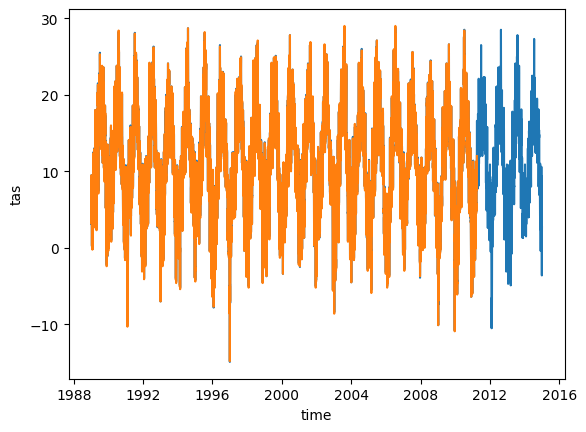

In [6]:
import seaborn as sns
sns.lineplot(data=hyras_df,x=hyras_df.index,y='tas')
sns.lineplot(data=df_station,x=df_station.index,y='value')

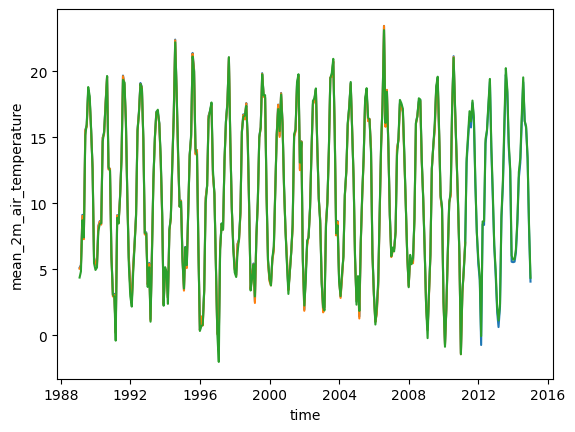

In [2]:
hyras_ds['tas'].resample(time='1M').mean().plot()
ds_time['value'].resample(time='1M').mean().plot()
era5_ds['mean_2m_air_temperature'].resample(time='1M').mean().plot()
# era5_land#['value'].resample(time='1M').mean().plot()

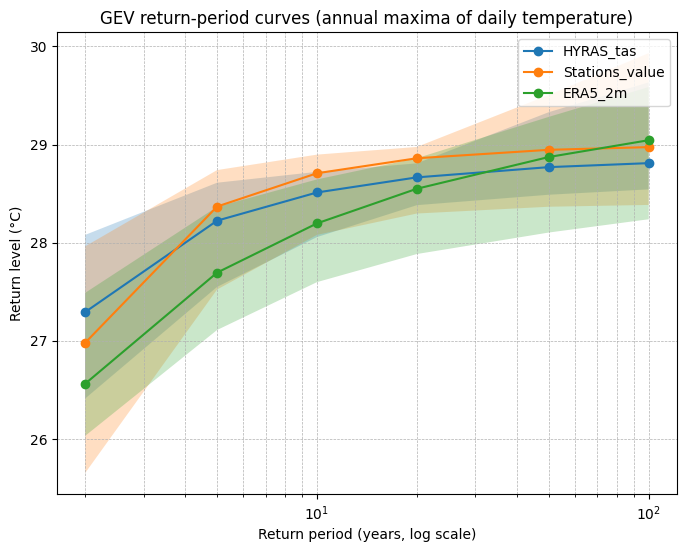

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import genextreme
from tqdm import tqdm  # optional, for bootstrap progress

# ---------- helper functions ----------
def maybe_kelvin_to_celsius(arr):
    """If data appear to be in Kelvin (mean > 200), convert to C."""
    if np.nanmean(arr) > 200:
        return arr - 273.15
    return arr

def annual_maxima(da):
    """Return 1D array (years) of annual maxima for a DataArray `da` with time coordinate."""
    # ensure time is datetime64
    if not np.issubdtype(da['time'].dtype, np.datetime64):
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))
    # compute annual maxima using calendar year
    ann = da.resample(time="1Y").max(dim="time", skipna=True)
    # drop years with all-nans
    ann = ann.dropna(dim="time", how="all")
    # return 1d numpy array
    return ann.values.ravel(), ann['time'].values

def fit_gev(annual_vals):
    """Fit GEV using MLE (scipy). Returns shape, loc, scale"""
    # genextreme in scipy uses shape parameter c (note sign convention),
    # fit returns (c, loc, scale)
    # remove nans
    vals = np.asarray(annual_vals)
    vals = vals[~np.isnan(vals)]
    if len(vals) < 3:
        raise ValueError("Need at least 3 annual maxima to fit GEV.")
    params = genextreme.fit(vals)  # (c, loc, scale)
    return params

def return_levels_from_params(params, return_periods):
    """
    Given GEV params (c, loc, scale) and return_periods (years),
    return the return level z_T for each T.
    z_T = F^{-1}(1 - 1/T) where F is GEV CDF.
    """
    probs = 1 - 1/np.array(return_periods)
    z = genextreme.ppf(probs, *params)
    return z

def bootstrap_return_levels(annual_vals, return_periods, n_boot=1000, random_state=None):
    """Bootstrap resampling of annual maxima to estimate CI for return levels."""
    rng = np.random.default_rng(random_state)
    n = len(annual_vals)
    rl_boot = np.empty((n_boot, len(return_periods)))
    for i in range(n_boot):
        sample = rng.choice(annual_vals, size=n, replace=True)
        try:
            params_bs = fit_gev(sample)
            rl_boot[i, :] = return_levels_from_params(params_bs, return_periods)
        except Exception:
            rl_boot[i, :] = np.nan
    # compute 2.5% and 97.5% quantiles, ignoring NaNs
    lower = np.nanpercentile(rl_boot, 2.5, axis=0)
    upper = np.nanpercentile(rl_boot, 97.5, axis=0)
    median = np.nanpercentile(rl_boot, 50, axis=0)
    return median, lower, upper

# ---------- main pipeline ----------
def gev_return_period_curve(da, label, return_periods=None, n_boot=500, convert_kelvin=True):
    """
    Input:
      da : xarray.DataArray (daily time series for one source, maybe multi-station -> will be flattened)
      label : string for legend
      return_periods : list-like of return periods in years
      n_boot : number of bootstrap resamples
    Returns:
      dict with keys: label, params, return_periods, rl (levels), rl_ci_lower, rl_ci_upper
    """
    if return_periods is None:
        return_periods = np.array([2,5,10,20,50,100,200,500])
    else:
        return_periods = np.array(return_periods)

    # If DataArray has station dimension, reduce to spatial average or handle first station.
    # Here we assume da is for a single location (1D time). If it's multi-station, user should pass one series.
    # If multi-dim, try to collapse spatial dims by mean (or pick the first)
    if da.ndim > 1:
        # choose mean over other dims except time
        non_time_dims = [d for d in da.dims if d != "time"]
        if non_time_dims:
            da_use = da.mean(dim=non_time_dims, skipna=True)
        else:
            da_use = da
    else:
        da_use = da

    # unit conversion check
    arr = da_use.values.astype(float)
    if convert_kelvin:
        arr = maybe_kelvin_to_celsius(arr)

    # create xarray DataArray with cleaned values
    da_clean = xr.DataArray(arr, coords={"time": da_use['time']}, dims=("time"))

    # annual maxima
    ann_vals, ann_times = annual_maxima(da_clean)

    # fit GEV
    params = fit_gev(ann_vals)

    # return levels
    rl = return_levels_from_params(params, return_periods)

    # bootstrap CIs (may be slow)
    median_bs, lower_bs, upper_bs = bootstrap_return_levels(ann_vals, return_periods, n_boot=n_boot, random_state=0)

    res = dict(
        label=label,
        params=params,
        return_periods=return_periods,
        rl=rl,
        rl_ci_lower=lower_bs,
        rl_ci_upper=upper_bs,
        ann_vals=ann_vals,
        ann_times=ann_times
    )
    return res

# ---------- apply to your three sources ----------
# replace these with your DataArrays
da1 = hyras_ds['tas']             # daily DataArray
da2 = ds_time['value']            # daily DataArray (from station coll.)
da3 = era5_ds['mean_2m_air_temperature']  # daily DataArray


results = []
for da, name in zip([da1, da2, da3], ["HYRAS_tas", "Stations_value", "ERA5_2m"]):
    res = gev_return_period_curve(da, name, return_periods=[2,5,10,20,50,100], n_boot=500)
    results.append(res)

# ---------- plotting ----------
plt.figure(figsize=(8,6))
for r in results:
    rp = r['return_periods']
    rl = r['rl']
    lower = r['rl_ci_lower']
    upper = r['rl_ci_upper']
    plt.plot(rp, rl, marker='o', label=r['label'])
    plt.fill_between(rp, lower, upper, alpha=0.25)

plt.xscale('log')
plt.xlabel('Return period (years, log scale)')
plt.ylabel('Return level (°C)')
plt.title('GEV return-period curves (annual maxima of daily temperature)')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [ ]:

era5_land_df['time'] = pd.to_datetime(era5_land_ds['time'])
era5_land_ds = era5_land_ds.set_index(['id', 'time']).to_xarray()



ValueError: the first argument to .set_index must be a dictionary